In [1]:
import warnings

warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt

import os

import random

from utils import *

In [3]:
save_files = True

## Images

In [4]:
images = []

files = os.listdir('data/extracted')
files.sort()

for file in files:
    
    if 'png' not in file:
        continue
        
    images.append((file, plt.imread('data/extracted/{}'.format(file))))
    
len(images)

4174

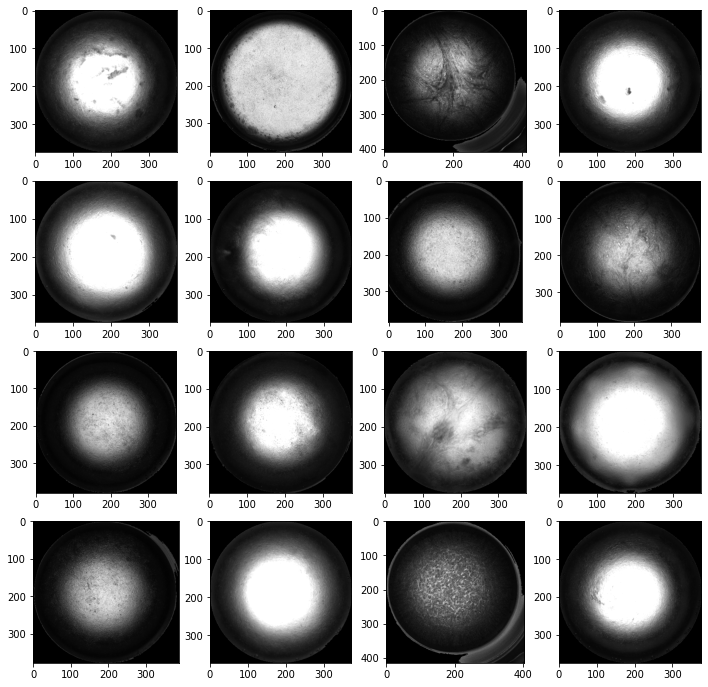

In [5]:
display_random_images(images, k=16, figsize=(12, 12))

Check if there are any images too dark/light which could mean that the extracted cell is invalid. Only look at the range of [0, 0.1] since that's where the black is occuring

count      4174.000000
mean      70580.647101
std       22697.258411
min       20740.000000
25%       47808.500000
50%       75340.500000
75%       90163.250000
max      119462.000000
dtype: float64

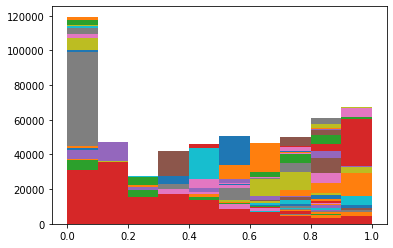

In [6]:
bins = np.arange(0, 1.1, 0.1)
hist_vals = []

for img in images:
    
    val = plt.hist(img[1].reshape(-1), bins=bins)
    # Save the first bin [0, 0.1] values
    hist_vals.append(val[0][0])
    
hist_vals = pd.Series(hist_vals)
hist_vals.describe()

In [7]:
min_index = hist_vals[hist_vals==hist_vals.min()].index.item()

1923


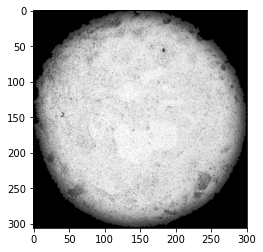

In [8]:
print(min_index)
plt.imshow(images[min_index][1], cmap='gray')

seems okay

Check records 2 stds away from mean

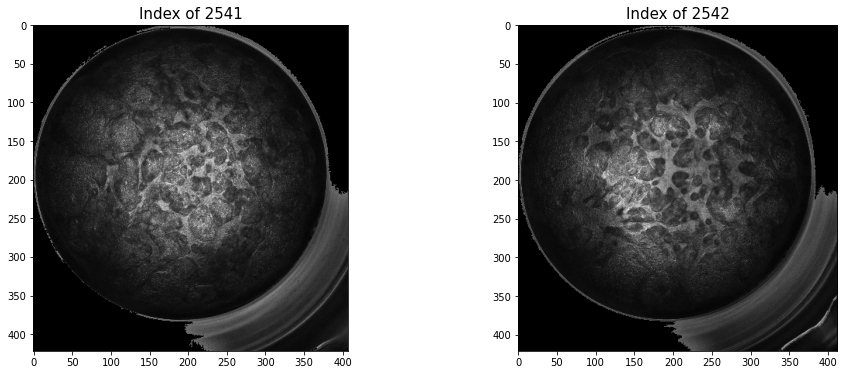

In [9]:
std_2 = hist_vals[hist_vals>hist_vals.std()*2+hist_vals.mean()]
fig, ax = plt.subplots(1, len(std_2), figsize=(16, 6))

for i, ind in enumerate(std_2.index):
    
    ax[i].imshow(images[ind][1], cmap='gray')
    ax[i].set_title('Index of {}'.format(ind), fontsize=15)

There are some noise in the cells but look okay to be used

In [10]:
# to_drop = [561, 910, 925, 2281, 2759]
# to_drop = [images[x][0] for x in to_drop]
to_drop = []

In [11]:
new_images = [
    x for x in images if x[0] not in to_drop
]

In [12]:
len(images), len(new_images)

(4174, 4174)

Measure width and height of each image to store them with same size later

In [13]:
max_width, max_height = 0, 0
max_h_image, max_w_image = None, None

for img in new_images:
    w, h = img[1].shape[1], img[1].shape[0]
    
    if w > max_width:
        max_width = w
        max_w_image = img[0]
        
    if h > max_height:
        max_height = h
        max_h_image = img[0]
        
print('Max Height {}\tMax Width {}'.format(max_height, max_width))

Max Height 436	Max Width 427


New size will have 448x448. This is because there are many pre-trained models that have been trained with images of 448x448 sizes

In [14]:
h, w = 448, 448

resized_images = []

for img in new_images:
    
    img_w, img_h = img[1].shape[1], img[1].shape[0]
    
    padding_w = (w - img_w) // 2
    padding_h = (h - img_h) // 2
    
    new_image = np.zeros((w, h))
    new_image[padding_h:padding_h+img_h, padding_w:padding_w+img_w] = img[1]
    
    resized_images.append((img[0], new_image))

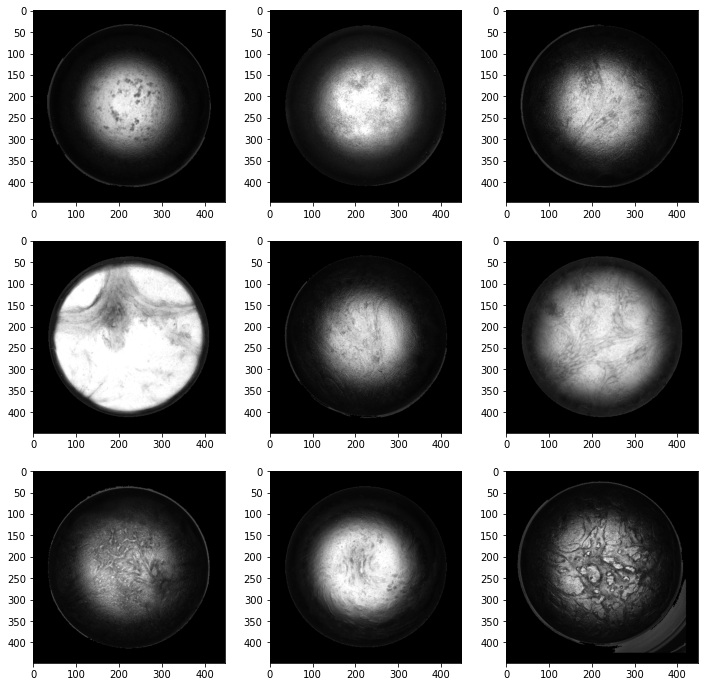

In [15]:
display_random_images(resized_images, k=9, figsize=(12, 12))

In [16]:
if not os.path.exists('data/processed_images'):
    os.makedirs('data/processed_images')
    
for i, image in enumerate(resized_images):

    if save_files:
        plt.imsave('data/processed_images/{}'.format(image[0]), image[1])
        print('{}/{} have been saved'.format(i+1, len(resized_images)), end='\r', flush=True)

### Create Mapping

In [17]:
csv_files = [
    'STEP1_MAG.csv',
    'STEP1C_Results.csv',
    # 'STEP2_ABS_GRP.csv',
    # 'STEP2_MAG_GRP.csv',
    # 'STEP2_SLIM_TTEST_ABS.csv',
    # 'STEP2_SLIM_TTEST_MAG.csv'
]

In [18]:
runs = pd.DataFrame(columns=['RUN', 'IMAGE_ID'] + [x.replace('.csv', '') for x in csv_files])
runs.columns = runs.columns.str.upper()
runs['IMAGE_ID'] = ['data/extracted/'+x[0] for x in images]
runs['RUN'] = [x.split('_')[0].split('/')[-1] for x in runs['IMAGE_ID']]

In [19]:
for csv in csv_files:
    file_name = runs['RUN'].str[:3].str.upper() + '_00' + runs['RUN'].str[-2:] + '_' + csv
    c = csv.replace('.csv', '').upper()
    runs[c] = 'data/zero_hour_csv/' + file_name

In [20]:
runs.sample(10)

,RUN,IMAGE_ID,STEP1_MAG,STEP1C_RESULTS
1506,Run35,data/extracted/Run35_0Hr_XY76_00001_CH4.png,data/zero_hour_csv/RUN_0035_STEP1_MAG.csv,data/zero_hour_csv/RUN_0035_STEP1C_Results.csv
408,Run17,data/extracted/Run17_0Hr_XY24_00001_CH4.png,data/zero_hour_csv/RUN_0017_STEP1_MAG.csv,data/zero_hour_csv/RUN_0017_STEP1C_Results.csv
3439,Run72,data/extracted/Run72_0Hr_XY53_00001_CH4.png,data/zero_hour_csv/RUN_0072_STEP1_MAG.csv,data/zero_hour_csv/RUN_0072_STEP1C_Results.csv
339,Run15,data/extracted/Run15_0Hr_XY29_00001_CH4.png,data/zero_hour_csv/RUN_0015_STEP1_MAG.csv,data/zero_hour_csv/RUN_0015_STEP1C_Results.csv
3715,Run76,data/extracted/Run76_0Hr_XY73_00001_CH4.png,data/zero_hour_csv/RUN_0076_STEP1_MAG.csv,data/zero_hour_csv/RUN_0076_STEP1C_Results.csv
2270,Run50,data/extracted/Run50_0Hr_XY83_00001_CH4.png,data/zero_hour_csv/RUN_0050_STEP1_MAG.csv,data/zero_hour_csv/RUN_0050_STEP1C_Results.csv
230,Run13,data/extracted/Run13_0Hr_XY41_00001_CH4.png,data/zero_hour_csv/RUN_0013_STEP1_MAG.csv,data/zero_hour_csv/RUN_0013_STEP1C_Results.csv
3856,Run78,data/extracted/Run78_0Hr_XY78_00001_CH4.png,data/zero_hour_csv/RUN_0078_STEP1_MAG.csv,data/zero_hour_csv/RUN_0078_STEP1C_Results.csv
332,Run15,data/extracted/Run15_0Hr_XY21_00001_CH4.png,data/zero_hour_csv/RUN_0015_STEP1_MAG.csv,data/zero_hour_csv/RUN_0015_STEP1C_Results.csv
1325,Run33,data/extracted/Run33_0Hr_XY64_00001_CH4.png,data/zero_hour_csv/RUN_0033_STEP1_MAG.csv,data/zero_hour_csv/RUN_0033_STEP1C_Results.csv


Check if there are any csv files missing

In [21]:
csv_files = pd.Series(os.listdir('data/zero_hour_csv'))
csv_files = ['data/zero_hour_csv/'+x for x in csv_files]
print(runs[runs['STEP1C_RESULTS'].isin(csv_files)].shape, runs[~runs['STEP1C_RESULTS'].isin(csv_files)].shape)

(3507, 4) (667, 4)


In [22]:
# Uncomment this to save the mapping
if save_files:
    runs[runs['STEP1C_RESULTS'].isin(csv_files)].to_csv('data/image_csv_mapping.csv', index=False)